In [1045]:
from pyelasticsearch.client import ElasticSearch
import json
import requests
import pandas as pd
import math
import numpy as np
import boto3
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import time
from ggplot import *
import random
from numpy.random import permutation

In [82]:
config = json.load(open('../config/configsql.json', 'r'))
aws_access_key_id=config['dev']['aws']['key']
aws_secret_access_key=config['dev']['aws']['secret']
region = 'us-east-1'
endpoint = config['dev']['endpoint']
bucketname=config['dev']['bucketname']['bucketname']
index_name1 = 'candidates_cv'
index_name2 = 'parsed_resume'
index_name3 = 'app_skill_list'
es = ElasticSearch(endpoint, port=443)
comprehend = boto3.client(service_name='comprehend',aws_access_key_id=aws_access_key_id, aws_secret_access_key=aws_secret_access_key,region_name = region)

In [799]:
pd.set_option('display.height',1000)
pd.set_option('display.max_rows',500)
pd.set_option('display.max_columns',500)
pd.set_option('display.width',1000)

# all dict

In [83]:
d_all = es.search(index = index_name1, query={
                                     "query": {"match_all": {}},
                                     "size":  5
                                     })

In [4]:
all_user = {}
for i in range(len(d_all['hits']['hits'])):
    user = d_all['hits']['hits'][i]['_source']
    id = d_all['hits']['hits'][i]['_id']
    all_user[id] = user

# parsed resume

In [6]:
def extract_information(user_record):
    resp = {}
    for element in ['education', 'summary', 'projects', 'experience']:
        if element in user_record:
            text = user_record[element]
            #print(element,len(text))
            entity = comprehend.detect_entities(Text=text, LanguageCode='en')
            keyword = comprehend.detect_key_phrases(Text=text, LanguageCode='en')
        else:
            entity = {}
            keyword = {}
        resp[element] = {"entities": entity, "keywords": keyword}
    return resp

In [16]:
def ASCII(s):
    if s is None:
        return ''
    s2 = ''
    for i in range(len(s)):
        x = ord(s[i])
        if x >= 32 and x < 128:
            s2 += s[i]
        else:
            s2 += ' '
    return s2

In [ ]:
resp_all = {}
for id in all_user.keys():
    print(id)
    user = all_user[id]
    for key in user.keys():
        user[key] = ASCII(user[key])
        if len(user[key]) > 5000:
            user[key] = user[key][0:5000]
    result = extract_information(user)
    resp_all[id] = result

# update to elasticsearch

In [2056]:
for id in resp_all.keys():
    user = resp_all[id]
    result = es.index(index_name2,'parsed_resume',user, id = id )

In [841]:
all_d = es.search(index = index_name2, query={"query": {"match_all": {}},
                                               "size":  622})

# all source

In [21]:
sources = ['education', 'summary','experience','projects']

In [22]:
results = []
for element in sources:
    result = es.search(index = index_name2, query=
    {
      "_source": element + '.keywords.KeyPhrases.Text',
      "size": 0,
      "aggs": {
        "group_by_coll_conv": {
          "terms": {
            "field": element + ".keywords.KeyPhrases.Text.keyword",
            "size" : 500
          },
          "aggs": {
            "count" : {
              "value_count" : 
                { 
                  "field" : element + ".keywords.KeyPhrases.Text.keyword"
                } 
            }
        }
    }
}})
    results.append(result)

In [24]:
results_all = []
for i in range(len(results)):
    result_all = results[i]['aggregations']['group_by_coll_conv']['buckets']
    results_all.append(result_all)

In [26]:
dfs = []
for j in range(len(sources)):
    source = sources[j]
    keys = []
    for i in results_all[j]:
        key = i['key']
        keys.append(key)
    doc_counts = []
    for i in results_all[j]:
        doc_count = i['doc_count']
        doc_counts.append(doc_count)
    values = []
    for i in results_all[j]:
        value = i['count']['value']
        values.append(value)
    for i in results_all[j]:
        idfs = np.log([results[0]['hits']['total']/x for x in doc_counts]).tolist()
    for i in results_all[j]:
        tf = [x/sum(values) for x in values]
    for i in result_all[j]:
        tf_idf = [a*b for a,b in zip(tf,idfs)]
    aa = pd.DataFrame(
        {'word': keys,
         'doc_count': doc_counts,
         'values': values,
         'source': source,
         'idf':idfs,
         'tf':tf,
         'tf_idf':tf_idf
        })
    dfs.append(aa)

df = pd.concat(dfs)
df.reset_index(drop=True,inplace = True)
df= df.sort_values(by=['tf','word'], ascending=[False, True])

In [27]:
pd.options.display.max_columns = 999
pd.options.display.max_rows = 999

In [599]:
df.sort_values('word')

,doc_count,idf,source,tf,tf_idf,values,word
1819,2,5.739793,projects,0.000934,0.005360,200,"""AVR Microcontrollers"
1820,2,5.739793,projects,0.000934,0.005360,200,"""Dynamical Systems"
1821,2,5.739793,projects,0.000934,0.005360,200,"""Linear and Nonlinear Kalman Filter"
1822,2,5.739793,projects,0.000934,0.005360,200,"""Linear and Nonlinear Kalman Filters"
1823,2,5.739793,projects,0.000934,0.005360,200,"""Signal Processing"
1824,2,5.739793,projects,0.000934,0.005360,200,"""Single-channel and Multi-channel Blind"
429,2,5.739793,education,0.001235,0.007086,462,#ED33C-0949
430,2,5.739793,education,0.001235,0.007086,462,#H33G-1475
431,2,5.739793,education,0.001235,0.007086,462,#H34D-03. 2 [13] Sara Sadri
432,2,5.739793,education,0.001235,0.007086,462,#H53J-1547


In [600]:
df2 = df

In [601]:
df2['word'] = [x.lower() for x in df2['word']]

In [602]:
df3 = pd.DataFrame(df2.groupby(['word'])['doc_count'].sum())

In [603]:
df3.columns = ['count']

In [604]:
df3 = df3.reset_index()

In [605]:
df3.head()

,word,count
0,"""avr microcontrollers",2
1,"""dynamical systems",2
2,"""linear and nonlinear kalman filter",2
3,"""linear and nonlinear kalman filters",2
4,"""signal processing",2


In [606]:
def num_there(s):
    return any(i.isdigit() for i in s)

In [607]:
word_list = df3['word'].tolist()

In [18]:
df_num = pd.DataFrame([num_there(i) for i in word_list])

In [19]:
df4 = pd.concat([df3,df_num], axis=1)

In [20]:
df_no_num = df4[df4.loc[:][0]==False]

In [21]:
df_no_num .reset_index(drop=True, inplace=True)

In [22]:
# ''.join(filter(str.isalnum, string))

In [650]:
def remove_spe_chara(string):

    return re.sub(r'\W+', ' ', string)

In [45]:
no_spec_list = df_no_num['word'].tolist()

In [46]:
df_no_spe = pd.DataFrame([remove_spe_chara(i) for i in no_spec_list])

In [47]:
df_no_spe=df_no_spe.rename(columns = {0:'word2'})

In [48]:
df_final = pd.concat([df_no_num,df_no_spe],axis=1)

In [ ]:
df_final = df_final.reset_index()

In [50]:
df_final = df_final.reset_index()

In [231]:
df_final.to_clipboard()

In [51]:
df_final.head()

,index,word,count,0,word2
0,0,"""avr microcontrollers",2,False,avr microcontrollers
1,1,"""dynamical systems",2,False,dynamical systems
2,2,"""linear and nonlinear kalman filter",2,False,linear and nonlinear kalman filter
3,3,"""linear and nonlinear kalman filters",2,False,linear and nonlinear kalman filters
4,4,"""signal processing",2,False,signal processing


In [29]:
df_skill = pd.read_csv('skillset.csv')

In [31]:
df_skill_app = df_skill.loc[df_skill['is_approved']==1]

In [32]:
df_skill_app = df_skill_app[['word','is_approved','doc_count']]

In [99]:
df_skill_app.head()

,word,is_approved,doc_count
0,python,1,272
1,machine learning,1,197
2,analysis,1,154
3,algorithms,1,124
4,matlab,1,118


In [159]:
#for i in range(len(df_skills)):
    #docs = {'keyword': df_skills[i]}
    #result = es.index(index='app_skill_list',doc_type='approved_skills', doc = docs)

In [295]:
for i in range(len(df_skills)):
    docs = {'keyword': df_skills[i]}
    result = es.index(index_name3, 'approved_skills' ,docs, id = df_skills[i])

In [296]:
es.search(index = 'app_skill_list', query={"query": {"match_all": {}},
                                               "size":  5})

{'_shards': {'failed': 0, 'successful': 5, 'total': 5},
 'hits': {'hits': [{'_id': 'bayesian statistics',
    '_index': 'app_skill_list',
    '_score': 1.0,
    '_source': {'keyword': 'bayesian statistics'},
    '_type': 'approved_skills'},
   {'_id': 'mechanical engineering',
    '_index': 'app_skill_list',
    '_score': 1.0,
    '_source': {'keyword': 'mechanical engineering'},
    '_type': 'approved_skills'},
   {'_id': 'visualization',
    '_index': 'app_skill_list',
    '_score': 1.0,
    '_source': {'keyword': 'visualization'},
    '_type': 'approved_skills'},
   {'_id': 'numerical analysis',
    '_index': 'app_skill_list',
    '_score': 1.0,
    '_source': {'keyword': 'numerical analysis'},
    '_type': 'approved_skills'},
   {'_id': 'cnn',
    '_index': 'app_skill_list',
    '_score': 1.0,
    '_source': {'keyword': 'cnn'},
    '_type': 'approved_skills'}],
  'max_score': 1.0,
  'total': 320},
 'timed_out': False,
 'took': 0}

In [294]:
#es.delete_index('app_skill_list')

In [233]:
top1 = es.search(index = index_name2, query={"query": {"match_all": {}},
                                               "size":  1})

In [ ]:
all_d = es.search(index = index_name2, query={"query": {"match_all": {}},
                                               "size":  622})

In [1072]:
def extract_cleaned_skill(user_record):
    all_skills = {}
    skills = []
    id = user_record['_id']
    for element in ['education', 'summary', 'projects','experience']:
        if len(user_record['_source'][element]['keywords']) > 0:
            skill_d = user_record['_source'][element]['keywords']['KeyPhrases']         
            for i in range(len(skill_d)):
                skill = skill_d[i]['Text'].lower()
                skill = re.sub(r'\W+', ' ', skill)
                skill = skill.strip()
                skills.append(skill)
    skills = [x for x in skills if not any(c.isdigit() for c in x)]
    all_skills = {'id': id, "keyword" : skills}
    return all_skills

In [843]:
results = []
for i in range(len(all_d['hits']['hits'])):
    user = all_d['hits']['hits'][i]
    result = extract_cleaned_skill(user)
    results.append(result)

In [844]:
user_skill = {}
for i in range(len(results)):
    id = results[i]['id']
    keyword = results[i]['keyword']
    user_skill[id] = keyword

In [688]:
skill_set = es.search(index = index_name3, query={"query": {"match_all": {}},
                                               "size":  320})

In [689]:
app_skills = []
for i in range(len(skill_set['hits']['hits'])):
    skills = skill_set['hits']['hits'][i]['_id']
    app_skills.append(skills)

In [846]:
match = {}
for i in range(len(results)):
    id = results[i]['id']
    user_s = user_skill[id]
    aa = set(user_s)& set(app_skills)
    match[id] = aa

In [849]:
rows = []
for i in range(len(match)):
    id = [x for x in match.keys()][i]
    kws = list(match[id])
    for kw in kws:
        row = [id,kw,1]
        rows.append(row)
match_df = pd.DataFrame(rows)    
match_df.columns = ['id', 'keyword','value']

In [850]:
match_df.head()

,id,keyword,value
0,https://s3.amazonaws.com/careers.dataskeptic.c...,pig,1
1,https://s3.amazonaws.com/careers.dataskeptic.c...,agile,1
2,https://s3.amazonaws.com/careers.dataskeptic.c...,etl,1
3,https://s3.amazonaws.com/careers.dataskeptic.c...,engineering,1
4,https://s3.amazonaws.com/careers.dataskeptic.c...,hive,1


In [939]:
match_df_p = match_df.pivot(index='id', columns='keyword', values='value')
match_df_p.fillna('0',inplace=True)
match_df_p.reset_index(inplace=True)

In [970]:
match_df_p.shape

(539, 321)

In [862]:
y = 0
for col in match_df_p.columns:
    s = match_df_p[col].astype(float)
    x = sum(s)
    y += x
print(y)

4622.0


# make pca model

In [948]:
match_df_pca.head()

keyword,a b c inventory analysis,a b testing,a classical non linear financial portfolio optimization project,a database,a datawarehouse,a detailed analytical approach,a mathematical model,a predictive model,a recommendation system,a text mining project,actuaries,aerospace engineering,agile,agile methodology,ai,ajax link,algorithm,algorithm development,algorithms,an algorithm,an analytical and numerical model,an android app,analysis,analytical models,analytical solutions,analytics,analytics fraud analytics,analyzed and developed web based applications,analyzed uber tweets,analyzing twitter data,android,angular,anomalies,anova,apache hadoop,apache hadoop flume and hive frame work,apache mahout,apache pig,apache spark,apis,application development,applied data mining,applied linear regression,applied mathematics,applied mathematics gpa,applied natural language processing,applied operations research,applied probability,applied statistics,applied three sampling techniques,applied time series,apr,arcgis,arcgis grass ogr updated levee and defense information,ariba e sourcing,arima model,artificial intelligence,avr microcontrollers,aws,backward step algorithms,bagging technique,bank marketing,bash,batch scheduling,bayesian model,bayesian model averaging,bayesian net,bayesian networks,bayesian regression model,bayesian statistics,big data technologies,bijective matrix algebra,bing ads,binning,biomedical signal processing machine learning,bpm,building automating and maintaining custom workflows,building effective question answering characters,business administration,business analytics,business and data analytics,business insights,business intelligence,business intelligence data mining project,c c,cassandra,chemical engineering,circuit analysis,civil and environmental engineering,civil engineering,classification algorithms,cloud computing,cluster,cluster analysis,clustering,clustering modeling,clusters,cmu sphinx,cnn,cognos data manager,communication skills,computer engineering,computer networks,copq,crm,cross validation,css,cuda c,data analyses,data analysis,data analytics,data collection,data explorations,data extraction,data informatics,data management,data mining,data munging,data pipeline,data processing,data science,data visualization,data warehouse,data warehousing,database,database administration,database design hotspot detection,database management,databases,decision tree,decision trees,deep learning,design and analysis,digital marketing,digital signal processing,dimensionality reduction,distributed databases,dyanmodb,dynamodb,e r modeling technique,electrical engineering,emails and sentiment analysis,engineering,enterprise data warehousing,etl,etl process,excel,excel vba,exploratory analysis,exploratory data analysis,financial engineering,forecast use,fortran,git,github,glew,google adwords,google analytics,google earth api,google keyword api,hadoop,hadoop flume and hive,hadoop hive and flume,hive,hive and flume,hiveql,html,hue interface,hypothesis testing,ibm,image processing,industrial engineering,inforefiner tool,information security and software development,information systems,information technology,jar file,java,javascript,jcl,jcl bi edw team,jcl sql and pl sql coding,js,k means,k means clustering,k means clustering algorithm,k means clustering analyzing twitter data using hadoop,knn,linear algebra,linear and nonlinear kalman filter,linear and nonlinear kalman filters,linear models,linear programming,linear regression,linear regression model,linux,logistic regression,mac os,machine learning,machine learning algorithms,machine learning techniques,magento,management,mapreduce,marketing,marketing data,mat lab,mathematical modeling,mathematical statistics,mathematics,matlab,mechanical engineering,model based advanced process control techniques,modeling,modeling technique,modeling techniques,models,molecular dynamics,mongodb,ms access,ms excel,ms office,ms word,multivariate analysis,mysql,mysql server,mysql workbench,naive bayes,

In [1042]:
cols = [col for col in match_df_p.columns if col not in ['id']]
match_df_pca = match_df_p[cols]

In [1043]:
def make_pca_model(n_comp):
    pca = PCA(n_components=n_comp)
    x = match_df_pca.loc[:, cols].values
    principalComponents = pca.fit_transform(x)
    principalDf = pd.DataFrame(data = principalComponents, columns = ['component'+str(x) for x in range(1,n_comp+1)])
    finalDf = pd.concat([match_df_p[['id']],principalDf], axis = 1)
    print(sum(pca.explained_variance_ratio_))
    return finalDf

In [1044]:
aa = make_pca_model(8)

0.2711028996837413


In [1038]:
cols =  [col for col in aa.columns if col not in ['id']]
bb = aa[cols]

In [1040]:
n_sne = 539
rndperm = np.random.permutation(bb.shape[0])
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(bb.loc[rndperm[:n_sne],cols].values)

print ('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 539 samples in 0.001s...
[t-SNE] Computed neighbors for 539 samples in 0.014s...
[t-SNE] Computed conditional probabilities for sample 539 / 539
[t-SNE] Mean sigma: 0.281246
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.919712
[t-SNE] Error after 300 iterations: 0.714708
t-SNE done! Time elapsed: 4.179550886154175 seconds


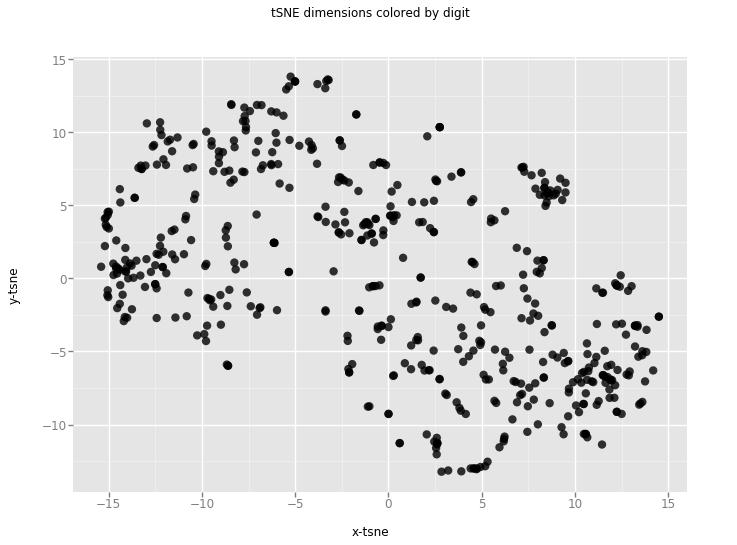

<ggplot: (339085274)>

In [1041]:
df_tsne = match_df_p.loc[rndperm[:n_sne],:].copy()
df_tsne['x-tsne'] = tsne_results[:,0]
df_tsne['y-tsne'] = tsne_results[:,1]
chart = ggplot( df_tsne, aes(x='x-tsne', y='y-tsne') ) + geom_point(size=70,alpha=0.8) + ggtitle("tSNE dimensions colored by digit")
chart

In [1062]:
match_df_p.head()

keyword,id,a b c inventory analysis,a b testing,a classical non linear financial portfolio optimization project,a database,a datawarehouse,a detailed analytical approach,a mathematical model,a predictive model,a recommendation system,a text mining project,actuaries,aerospace engineering,agile,agile methodology,ai,ajax link,algorithm,algorithm development,algorithms,an algorithm,an analytical and numerical model,an android app,analysis,analytical models,analytical solutions,analytics,analytics fraud analytics,analyzed and developed web based applications,analyzed uber tweets,analyzing twitter data,android,angular,anomalies,anova,apache hadoop,apache hadoop flume and hive frame work,apache mahout,apache pig,apache spark,apis,application development,applied data mining,applied linear regression,applied mathematics,applied mathematics gpa,applied natural language processing,applied operations research,applied probability,applied statistics,applied three sampling techniques,applied time series,apr,arcgis,arcgis grass ogr updated levee and defense information,ariba e sourcing,arima model,artificial intelligence,avr microcontrollers,aws,backward step algorithms,bagging technique,bank marketing,bash,batch scheduling,bayesian model,bayesian model averaging,bayesian net,bayesian networks,bayesian regression model,bayesian statistics,big data technologies,bijective matrix algebra,bing ads,binning,biomedical signal processing machine learning,bpm,building automating and maintaining custom workflows,building effective question answering characters,business administration,business analytics,business and data analytics,business insights,business intelligence,business intelligence data mining project,c c,cassandra,chemical engineering,circuit analysis,civil and environmental engineering,civil engineering,classification algorithms,cloud computing,cluster,cluster analysis,clustering,clustering modeling,clusters,cmu sphinx,cnn,cognos data manager,communication skills,computer engineering,computer networks,copq,crm,cross validation,css,cuda c,data analyses,data analysis,data analytics,data collection,data explorations,data extraction,data informatics,data management,data mining,data munging,data pipeline,data processing,data science,data visualization,data warehouse,data warehousing,database,database administration,database design hotspot detection,database management,databases,decision tree,decision trees,deep learning,design and analysis,digital marketing,digital signal processing,dimensionality reduction,distributed databases,dyanmodb,dynamodb,e r modeling technique,electrical engineering,emails and sentiment analysis,engineering,enterprise data warehousing,etl,etl process,excel,excel vba,exploratory analysis,exploratory data analysis,financial engineering,forecast use,fortran,git,github,glew,google adwords,google analytics,google earth api,google keyword api,hadoop,hadoop flume and hive,hadoop hive and flume,hive,hive and flume,hiveql,html,hue interface,hypothesis testing,ibm,image processing,industrial engineering,inforefiner tool,information security and software development,information systems,information technology,jar file,java,javascript,jcl,jcl bi edw team,jcl sql and pl sql coding,js,k means,k means clustering,k means clustering algorithm,k means clustering analyzing twitter data using hadoop,knn,linear algebra,linear and nonlinear kalman filter,linear and nonlinear kalman filters,linear models,linear programming,linear regression,linear regression model,linux,logistic regression,mac os,machine learning,machine learning algorithms,machine learning techniques,magento,management,mapreduce,marketing,marketing data,mat lab,mathematical modeling,mathematical statistics,mathematics,matlab,mechanical engineering,model based advanced process control techniques,modeling,modeling technique,modeling techniques,models,molecular dynamics,mongodb,ms access,ms excel,ms office,ms word,multivariate analysis,mysql,mysql server,mysql workbench,naive bay

In [1060]:
aa

,id,component1,component2,component3,component4,component5,component6,component7,component8
0,https://s3.amazonaws.com/careers.dataskeptic.c...,0.251584,-0.533296,0.250378,-1.330137,0.738595,0.308677,0.570163,-0.442651
1,https://s3.amazonaws.com/careers.dataskeptic.c...,6.864075,3.145020,-0.758587,0.455604,0.006654,-0.834046,-0.164389,0.149295
2,https://s3.amazonaws.com/careers.dataskeptic.c...,-0.313754,0.575899,-0.390614,0.019421,0.254655,0.334381,0.023920,0.100718
3,https://s3.amazonaws.com/careers.dataskeptic.c...,-0.224905,0.075491,-0.085752,-0.355877,-0.459791,-0.122237,-0.202355,-0.424784
4,https://s3.amazonaws.com/careers.dataskeptic.c...,-0.458009,0.626473,0.041747,-0.001848,-0.002829,-0.139362,0.042687,-0.032889
5,https://s3.amazonaws.com/careers.dataskeptic.c...,-0.092933,0.414425,0.906431,-0.177527,0.133000,0.147019,-0.120651,-0.183297
6,https://s3.amazonaws.com/careers.dataskeptic.c...,-0.459005,0.591182,0.014944,-0.013262,-0.115539,-0.153919,0.036003,-0.066871
7,https://s3.amazonaws.com/careers.dataskeptic.c...,-0.433498,0.569382,0.041409,-0.075688,0.033544,0.044224,0.052933,-0.328338
8,https://s3.amazonaws.com/careers.dataskeptic.c...,-0.011094,-0.086142,-0.836175,0.072340,1.052432,0.275095,-0.156423,-0.047292
9,https://s3.amazonaws.com/careers.dataskeptic.c...,0.089204,-0.034063,-1.130091,-0.420053,0.325106,0.493407,0.460400,0.815581


In [1049]:
random_indices = permutation(aa.index)
test_cutoff = math.floor(len(aa)/5)
test = aa.loc[random_indices[1:test_cutoff]]
train = aa.loc[random_indices[test_cutoff:]]

In [1067]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=5)

In [1070]:
test

,id,component1,component2,component3,component4,component5,component6,component7,component8
95,https://s3.amazonaws.com/careers.dataskeptic.c...,-0.095085,-0.080328,0.502120,0.018348,-0.686924,0.516349,-0.023812,-0.165664
153,https://s3.amazonaws.com/careers.dataskeptic.c...,-0.285492,0.368479,-0.130860,0.054595,0.185916,-0.046997,0.372770,-0.420520
538,https://s3.amazonaws.com/careers.dataskeptic.c...,-0.312938,0.561968,0.227164,-0.253729,0.064323,-0.176998,0.112858,0.052551
27,https://s3.amazonaws.com/careers.dataskeptic.c...,-0.253567,0.106785,-0.072680,-0.187125,-0.617760,0.125718,-0.309245,-0.153983
527,https://s3.amazonaws.com/careers.dataskeptic.c...,0.127778,-0.261596,-0.063807,-0.936859,-0.107721,-0.221970,0.226765,-0.114715
246,https://s3.amazonaws.com/careers.dataskeptic.c...,-0.254198,0.565524,0.153762,0.118521,-0.163072,-0.090750,-0.019879,-0.050010
513,https://s3.amazonaws.com/careers.dataskeptic.c...,0.287137,-0.159829,0.121539,0.484658,0.764562,1.097505,0.111002,0.691935
115,https://s3.amazonaws.com/careers.dataskeptic.c...,-0.191088,0.614501,0.306557,-0.283628,0.318033,-0.261736,-0.105647,0.044981
325,https://s3.amazonaws.com/careers.dataskeptic.c...,0.096862,0.571249,0.087561,-0.514493,0.864662,0.432790,-0.173023,-0.070065
148,https://s3.amazonaws.com/careers.dataskeptic.c...,-0.121716,-0.571330,-0.002022,0.424156,-0.709786,0.017001,-0.438010,-0.169595


In [ ]:
# save to parquet
# save to s3



In [2557]:
filename = 'terms.parquet'

In [ ]:
df.to_parquet(filename)

In [2559]:
s3.Bucket(bucketname).upload_file(filename,'sys/parsed-keywords_v1.parquet')